In [1]:
import sagemaker
from sagemaker import get_execution_role
role=get_execution_role()
session=sagemaker.Session()

In [31]:
bucket='semanti-segmentation-bkt'
prefix='segmentation-demo'


In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

In [4]:
training_image=get_image_uri(region_name=session.boto_region_name,repo_name='semantic-segmentation',repo_version='latest')
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


991648021394.dkr.ecr.ap-south-1.amazonaws.com/semantic-segmentation:latest


In [9]:
!pip install kaggle

     |████████████████████████████████| 59 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 118 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 5.2 MB/s eta 0:00:011
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73274 sha256=2cd2f91716a989e508f03415e6b394cd6b9a7ea04bb5b36ebeefb7e29ce66874
  Stored in directory: /home/ec2-user/.cache/pip/wheels/cf/aa/f0/ed1179bbcd729b29d0dfda59826fb3b55f0a4a0c3f713c1c82
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6767 sha256=bc456637e6d8ceb92ce8dd4dad0a71f1241f983bd08206d39a715caa33a1df69
  Stored in directory: /home/ec2-user/.cache/pip/wheels/72/e6/db/122611605e60148f54ee2abaca98b2bbeafc6e22486a867bad
  Created wheel for slugify: filename=slugify-0.0.1-py3-none-any.whl size=1908 sha256=9e261ef80958e78f7c6e11f4f9c5d4a546371732d3f1d76afa0c33e2509473ef
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7d/51/b0/c584cbdd0a8fc685d68677e58cde93

In [11]:
!mv kaggle.json /home/ec2-user/.kaggle
!kaggle datasets download -d huanghanchina/pascal-voc-2012

100%|█████████████████████████████████████▉| 3.63G/3.63G [02:49<00:00, 33.0MB/s]
100%|██████████████████████████████████████| 3.63G/3.63G [02:49<00:00, 23.0MB/s]


In [14]:
import os
os.listdir('data')


['voc2012', 'VOC2012']

In [15]:
os.listdir('data/voc2012/')


['VOC2012']

In [17]:
os.listdir('data/voc2012/VOC2012/')


['SegmentationClass',
 'SegmentationObject',
 'Annotations',
 'JPEGImages',
 'ImageSets']

In [16]:
os.listdir('data/VOC2012/')

['SegmentationClass',
 'SegmentationObject',
 'Annotations',
 'JPEGImages',
 'ImageSets']

In [20]:
print(len(os.listdir('data/voc2012//VOC2012/JPEGImages//')))

17125


In [21]:
!rm -rf pascal-voc-2012.zip

In [22]:
import shutil

In [26]:
os.makedirs('train',exist_ok=True)
os.makedirs('validation',exist_ok=True)
os.makedirs('train_annotation',exist_ok=True)
os.makedirs('validation_annotation',exist_ok=True)

#Creating a list of all training images

filename='data/VOC2012/ImageSets/Segmentation/train.txt'
with open(filename) as f:
    train_list=f.read().splitlines()
    
# Creating a list of all validation images
filename='data/VOC2012/ImageSets/Segmentation/val.txt'
with open(filename) as f:
    val_list=f.read().split()

# Now moving the jpeg images in the training_list to train dir, and png images to the train_annotation directory

for i in train_list:
    
    shutil.copy2('data/VOC2012/JPEGImages/'+i+'.jpg','train/')
    shutil.copy2('data/VOC2012/SegmentationClass/'+i+'.png','train_annotation/')
    
# Now moving the jpeg images in the validation_list to validation dir, and png images to the validation_annotation directory
    
for i in val_list:
    
    shutil.copy2('data/VOC2012/JPEGImages/'+i+'.jpg','validation/')
    shutil.copy2('data/VOC2012/SegmentationClass/'+i+'.png','validation_annotation/')
    

#### Validating that the move was accurate

In [27]:
import glob
num_train_samples=len(glob.glob1('train','*.jpg'))
print('num_training_samples='+str(num_train_samples))

assert num_train_samples== len(glob.glob1('train_annotation','*.png'))


print ( ' Num Validation Images = ' + str(len(glob.glob1('validation',"*.jpg"))))
assert len(glob.glob1('validation',"*.jpg")) == len(glob.glob1('validation_annotation',"*.png"))

num_training_samples=1464
 Num Validation Images = 1449


In [28]:

import json
label_map = { "scale": 1 }
with open('train_label_map.json', 'w') as lm_fname:
    json.dump(label_map, lm_fname)

* Creating the channels for the s3 bkt


In [29]:
# Create channel names for the s3 bucket.
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'
# label_map_channel = prefix + '/label_map'

In [32]:
%%time
# upload the appropraite directory up to s3 respectively for all directories.
session.upload_data(path='train', bucket=bucket, key_prefix=train_channel)
session.upload_data(path='validation', bucket=bucket, key_prefix=validation_channel)
session.upload_data(path='train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
session.upload_data(path='validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)
# sess.upload_data(path='train_label_map.json', bucket=bucket, key_prefix=label_map_channel)

CPU times: user 39.2 s, sys: 1.78 s, total: 41 s
Wall time: 3min 57s


's3://semanti-segmentation-bkt/segmentation-demo/validation_annotation'

* Specifying the output location where the model artifacts will be dumped

In [33]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print(s3_output_location)

s3://semanti-segmentation-bkt/segmentation-demo/output


## Training

In [45]:
# Create the sagemaker estimator object.
ss_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p2.16xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         output_path = s3_output_location,
                                         base_job_name = 'semantic-seg-demo',
                                         sagemaker_session = session)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


* Setting Hyperparameters

In [46]:
# Setup hyperparameters 
ss_model.set_hyperparameters(backbone='resnet-50', # This is the encoder. Other option is resnet-50
                             algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='True', # Use the pre-trained model.
                             crop_size=240, # Size of image random crop.                             
                             num_classes=21, # Pascal has 21 classes. This is a mandatory parameter.
                             epochs=50, # Number of epochs to run.
                             learning_rate=0.0001,                             
                             optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=16, # Setup some mini batch size.
                             validation_mini_batch_size=16,
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=2, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
                             num_training_samples=num_train_samples) # This is a mandatory parameter, 1464 in this case.

* Now we have to create s3_input_objects

In [47]:
# Create full bucket names
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

distribution = 'FullyReplicated'
# Create sagemaker s3_input objects
train_data = sagemaker.session.s3_input(s3_train_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [48]:
ss_model.fit(inputs=data_channels, logs=True)


2020-10-10 05:05:59 Starting - Starting the training job...
2020-10-10 05:06:01 Starting - Launching requested ML instances.........
2020-10-10 05:07:58 Starting - Preparing the instances for training............
2020-10-10 05:09:40 Downloading - Downloading input data...
2020-10-10 05:10:22 Training - Downloading the training image...
2020-10-10 05:10:54 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[10/10/2020 05:10:58 INFO 140238993069888] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u

### Hosting

In [54]:
ss_predictor = ss_model.deploy(initial_instance_count=1,endpoint_name='semantic-seg-endpt', instance_type='ml.t2.medium')


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: semantic-seg-demo-2020-10-10-05-05-58-877


-------------------!

* Inference

In [55]:
!wget -O test.jpg https://upload.wikimedia.org/wikipedia/commons/b/b4/R1200RT_in_Hongkong.jpg
filename = 'test.jpg'


--2020-10-10 06:32:47--  https://upload.wikimedia.org/wikipedia/commons/b/b4/R1200RT_in_Hongkong.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1047212 (1023K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   1023K  2.83MB/s    in 0.4s    

2020-10-10 06:32:48 (2.83 MB/s) - ‘test.jpg’ saved [1047212/1047212]



In [56]:
import matplotlib.pyplot as plt
from PIL import Image
img=Image.open('test.jpg')
img_size=img.size
print(img_size)

(2868, 2368)


In [57]:
# Resizing the img for inference
img.thumbnail([800,600],Image.ANTIALIAS)
filename='test_resized'
img.save(filename,'JPEG')


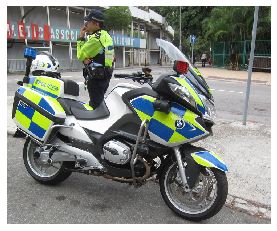

In [58]:

%matplotlib inline
plt.imshow(img)
plt.axis('off')
with open(filename, 'rb') as image:
    img = image.read()
    img = bytearray(img)

### Making Predictions

In [59]:
%%time 
ss_predictor.content_type = 'image/jpeg'
ss_predictor.accept = 'image/png'
return_img = ss_predictor.predict(img)

CPU times: user 21.9 ms, sys: 0 ns, total: 21.9 ms
Wall time: 13.2 s


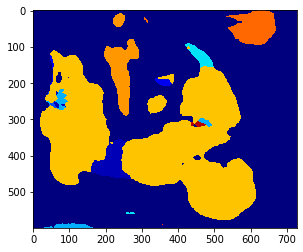

In [61]:
import io
import numpy as np

num_classes = 21
mask = np.array(Image.open(io.BytesIO(return_img)))
plt.imshow(mask, vmin=0, vmax=num_classes-1, cmap='jet')
plt.show()

* This will return the class probabilities of pixels

In [82]:
%%time
with open('test.jpg', 'rb') as image:
    full_img = image.read()
    full_img = bytearray(full_img)
ss_predictor.content_type = 'image/jpeg'
ss_predictor.accept = 'application/x-protobuf'
results = ss_predictor.predict(full_img)


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from model with message "unable to evaluate payload provided". See https://ap-south-1.console.aws.amazon.com/cloudwatch/home?region=ap-south-1#logEventViewer:group=/aws/sagemaker/Endpoints/semantic-seg-endpt in account 886035371869 for more information.

* Now we have to convert it into readable format

In [63]:
from sagemaker.amazon.record_pb2 import Record
import mxnet as mx

results_file = 'results.rec'
with open(results_file, 'wb') as f:
    f.write(results)

rec = Record()
recordio = mx.recordio.MXRecordIO(results_file, 'r')
protobuf = rec.ParseFromString(recordio.read())

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


* The protobuf array has two parts to it. The first part contains the shape of the output and the second contains the values of probabilites. Using the output shape, we can transform the probabilities into the shape of the image, so that we get a map of values. There typically is a singleton dimension since we are only inferring on one image. We can also remove that using the squeeze method.

In [65]:
%%time
values = list(rec.features["target"].float32_tensor.values)
shape = list(rec.features["shape"].int32_tensor.values)
shape = np.squeeze(shape)
mask = np.reshape(np.array(values), shape)
mask = np.squeeze(mask, axis=0)

CPU times: user 912 ms, sys: 165 ms, total: 1.08 s
Wall time: 1.07 s


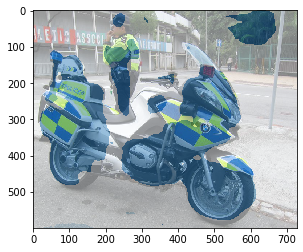

In [95]:
pred_map = np.argmax(mask, axis=0)
num_classes = 21
img=Image.open('test_resized')
plt.imshow(img,cmap='BrBG')
plt.imshow(pred_map, vmin=0, vmax=num_classes-1, cmap='Blues',alpha=0.49)
plt.show()

# Now we will retrain the model, using previous artifacts

* Providing the location of previous model artifacts

In [96]:
s3_previous_model_data='s3://semanti-segmentation-bkt/segmentation-demo/output/semantic-seg-demo-2020-10-10-05-05-58-877/output/model.tar.gz'
model_data=sagemaker.session.s3_input(s3_previous_model_data,content_type='application/x-sagemaker-model',
                                     s3_data_type='S3Prefix',distribution='FullyReplicated')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


* Specifying the output location of new model artifacts

In [97]:
s3_new_model_output_loc='s3://{}/{}/2nd_model_output'.format(bucket,prefix)

## Given the base estimator ,create a new one for incremental training

In [99]:
second_model_estimator = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p2.16xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         output_path = s3_new_model_output_loc,
                                         base_job_name = 'semantic-seg-second-',
                                         sagemaker_session = session,
                                                      model_uri=model_data)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [100]:
second_model_estimator.set_hyperparameters(backbone='resnet-50', # This is the encoder. Other option is resnet-50
                             algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='False', # Use the pre-trained model.
                             crop_size=240, # Size of image random crop.                             
                             num_classes=21, # Pascal has 21 classes. This is a mandatory parameter.
                             epochs=10, # Number of epochs to run.
                             learning_rate=0.004,                             
                             optimizer='adam', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=16, # Setup some mini batch size.
                             validation_mini_batch_size=16,
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=2, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=4, # No matter what, run these many number of epochs.                             
                             num_training_samples=num_train_samples) # This is a mandatory parameter, 1464 in this case.

In [101]:
second_model_estimator.fit(inputs=data_channels, logs=True)


2020-10-10 09:13:00 Starting - Starting the training job...
2020-10-10 09:13:03 Starting - Launching requested ML instances.........
2020-10-10 09:14:58 Starting - Preparing the instances for training.........
2020-10-10 09:16:32 Downloading - Downloading input data......
2020-10-10 09:17:28 Training - Downloading the training image...
2020-10-10 09:17:47 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[10/10/2020 09:17:50 INFO 139933683001152] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'

KeyboardInterrupt: 

# Now third model

In [105]:
s3_third_model_output_loc='s3://{}/{}/third_model_output'.format(bucket,prefix)

third_model_estimator = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p2.16xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         output_path = s3_third_model_output_loc,
                                         base_job_name = 'semantic-seg-third-',
                                         sagemaker_session = session
                                                      )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [106]:
third_model_estimator.set_hyperparameters(backbone='resnet-101', # This is the encoder. Other option is resnet-50
                             algorithm='deeplab', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='True', # Use the pre-trained model.
                             crop_size=340, # Size of image random crop.                             
                             num_classes=21, # Pascal has 21 classes. This is a mandatory parameter.
                             epochs=10, # Number of epochs to run.
                             learning_rate=0.002,                             
                             optimizer='adam', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=16, # Setup some mini batch size.
                             validation_mini_batch_size=16,
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=2, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=2, # No matter what, run these many number of epochs.                             
                             num_training_samples=num_train_samples) # This is a mandatory parameter, 1464 in this case.

In [107]:
third_model_estimator.fit(inputs=data_channels, logs=True)


2020-10-10 09:58:48 Starting - Starting the training job...
2020-10-10 09:58:50 Starting - Launching requested ML instances.........
2020-10-10 10:00:46 Starting - Preparing the instances for training............
2020-10-10 10:02:22 Downloading - Downloading input data...
2020-10-10 10:03:14 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[10/10/2020 10:03:32 INFO 140140575405888] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_aux_weight': u'0.5', u'_hybrid': u'False', u'_augmentation_type': u'default', u'lr_sched

# Now I am going to use again first model architecture, as in that mIOU was improving a bit

In [111]:
s3_fourth_model_output_loc='s3://{}/{}/fourth_model_output'.format(bucket,prefix)

fourth_model_estimator = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p2.16xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         output_path = s3_fourth_model_output_loc,
                                         base_job_name = 'semantic-seg-fourth-',
                                         sagemaker_session = session,
                                                      model_uri=model_data
                                                      )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [112]:
# Setup hyperparameters 
fourth_model_estimator.set_hyperparameters(backbone='resnet-50', # This is the encoder. Other option is resnet-50
                             algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='True', # Use the pre-trained model.
                             crop_size=240, # Size of image random crop.                             
                             num_classes=21, # Pascal has 21 classes. This is a mandatory parameter.
                             epochs=50, # Number of epochs to run.
                             learning_rate=0.0001,                             
                             optimizer='rmsprop',
                             gamma2=0.6,# Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=96, # Setup some mini batch size.
                             validation_mini_batch_size=96,
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=2, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
                             num_training_samples=num_train_samples) # This is a mandatory parameter, 1464 in this case.

In [113]:
fourth_model_estimator.fit(inputs=data_channels, logs=True)

2020-10-10 11:21:45 Starting - Starting the training job...
2020-10-10 11:21:48 Starting - Launching requested ML instances.........
2020-10-10 11:23:18 Starting - Preparing the instances for training............
2020-10-10 11:25:19 Downloading - Downloading input data...
2020-10-10 11:26:06 Training - Downloading the training image...
2020-10-10 11:26:32 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[10/10/2020 11:26:36 INFO 139845420713792] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'

In [120]:
forth_model_predictor = fourth_model_estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium',endpoint_name='forth-model-edpt')


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: semantic-seg-fourth--2020-10-10-11-21-44-956


---------------------!

## Now let's test the same image,as before

In [121]:
with open('test_resized.jpg', 'rb') as image:
    img = image.read()
    img = bytearray(img)

In [123]:
%%time 
forth_model_predictor.content_type = 'image/jpeg'
forth_model_predictor.accept = 'image/png'
return_img_from_4 = forth_model_predictor.predict(img)

CPU times: user 16.7 ms, sys: 202 µs, total: 16.9 ms
Wall time: 33 s


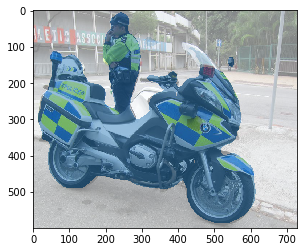

In [129]:
mask = np.array(Image.open(io.BytesIO(return_img_from_4)))
img=Image.open('test_resized.jpg')
plt.imshow(img,cmap='BrBG')
plt.imshow(mask, vmin=0, vmax=num_classes-1, cmap='Blues',alpha=0.5)
plt.show()

* Testing my own test image

In [133]:
img.size  # AS img is high resolution so taking a lot of time

(1280, 720)

In [149]:
%%time 


with open('my_test_img.jpg', 'rb') as image:
    img = image.read()
    img = bytearray(img)
    
forth_model_predictor.content_type = 'image/jpeg'
forth_model_predictor.accept = 'image/png'
return_img_from_4 = ss_predictor.predict(img)

# Sorry this image is not resized,so it will take too long on it

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from model with message "Your invocation timed out while waiting for a response from container model. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://ap-south-1.console.aws.amazon.com/cloudwatch/home?region=ap-south-1#logEventViewer:group=/aws/sagemaker/Endpoints/semantic-seg-endpt in account 886035371869 for more information.

* Now resizing the image

In [143]:
im =Image.open('my_test_img.jpg')
im.thumbnail([600,400],Image.ANTIALIAS)
im.save('my_test_resized.jpg', "JPEG")

In [152]:
%%time 


with open('my_test_resized.jpg', 'rb') as image:
    img = image.read()
    img = bytearray(img)
    
forth_model_predictor.content_type = 'image/jpeg'
forth_model_predictor.accept = 'image/png'
return_img_from_4 = forth_model_predictor.predict(img)


CPU times: user 5.45 ms, sys: 59 µs, total: 5.51 ms
Wall time: 4.96 s


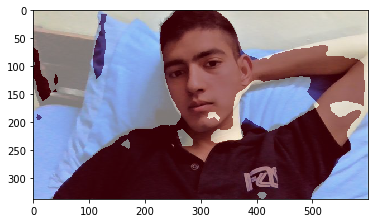

In [153]:

mask = np.array(Image.open(io.BytesIO(return_img_from_4)))
img=Image.open('my_test_resized.jpg')
plt.imshow(img,cmap='BrBG')
plt.imshow(mask, vmin=0, vmax=1, cmap='Reds',alpha=0.5)
plt.show()

## Now I will continue the fourth model structure, and will see if we can further lower the mIOU 

In [154]:
# Now model data will point to the artifacts of 4th model

s3_forth_model_data='s3://semanti-segmentation-bkt/segmentation-demo/fourth_model_output/semantic-seg-fourth--2020-10-10-11-21-44-956/output/model.tar.gz'
forth_model_data=sagemaker.session.s3_input(s3_previous_model_data,content_type='application/x-sagemaker-model',
                                     s3_data_type='S3Prefix',distribution='FullyReplicated')

s3_fifth_model_output_loc='s3://{}/{}/fifth_model_output'.format(bucket,prefix)

fifth_model_estimator = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p2.16xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         output_path = s3_fourth_model_output_loc,
                                         base_job_name = 'semantic-seg-fourth-',
                                         sagemaker_session = session,
                                                      model_uri=forth_model_data
                                                      )

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [158]:
# Adding gamma1,default was 0.9 ,now 0.5

# Setup hyperparameters 
fifth_model_estimator.set_hyperparameters(backbone='resnet-50', # This is the encoder. Other option is resnet-50
                             algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='True', # Use the pre-trained model.
                             crop_size=140, # Size of image random crop.                             
                             num_classes=21, # Pascal has 21 classes. This is a mandatory parameter.
                             epochs=5, # Number of epochs to run.
                             learning_rate=0.0001,                             
                             optimizer='rmsprop',
                             gamma1=0.5,
                             gamma2=0.6,# Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=96, # Setup some mini batch size.
                             validation_mini_batch_size=96,
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=2, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=3, # No matter what, run these many number of epochs.                             
                             num_training_samples=num_train_samples) # This is a mandatory parameter, 1464 in this 

In [159]:
fifth_model_estimator.fit(inputs=data_channels, logs=True)

2020-10-10 12:28:05 Starting - Starting the training job...
2020-10-10 12:28:08 Starting - Launching requested ML instances.........
2020-10-10 12:29:36 Starting - Preparing the instances for training.........
2020-10-10 12:31:35 Downloading - Downloading input data......
2020-10-10 12:32:23 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[10/10/2020 12:32:49 INFO 139876981618496] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_aux_weight': u'0.5', u'_hybrid': u'False', u'_augmentation_type': u'default', u'lr_sched

In [162]:

s3_forth_model_data='s3://semanti-segmentation-bkt/segmentation-demo/fourth_model_output/semantic-seg-fourth--2020-10-10-11-21-44-956/output/model.tar.gz'
forth_model_data=sagemaker.session.s3_input(s3_forth_model_data,content_type='application/x-sagemaker-model',
                                     s3_data_type='S3Prefix',distribution='FullyReplicated')

s3_fifth_model_output_loc='s3://{}/{}/fifth_model_output'.format(bucket,prefix)

fifth_model_estimatorr = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p2.16xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         output_path = s3_fourth_model_output_loc,
                                         base_job_name = 'semantic-seg-fifth-',
                                         sagemaker_session = session,
                                                      model_uri=forth_model_data
                                                      )

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [163]:

# Setup hyperparameters 
fifth_model_estimatorr.set_hyperparameters(backbone='resnet-50', # This is the encoder. Other option is resnet-50
                             algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='True', # Use the pre-trained model.
                             crop_size=140, # Size of image random crop.                             
                             num_classes=21, # Pascal has 21 classes. This is a mandatory parameter.
                             epochs=20, # Number of epochs to run.
                             learning_rate=0.0001,                             
                             optimizer='rmsprop',
                             gamma1=0.5,
                             gamma2=0.6,# Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='cosine', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=112, # Setup some mini batch size.
                             validation_mini_batch_size=112,
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=3, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=7, # No matter what, run these many number of epochs.                             
                             num_training_samples=num_train_samples) # This is a mandatory parameter, 1464 in this 

In [164]:
fifth_model_estimatorr.fit(inputs=data_channels, logs=True)

2020-10-10 12:45:47 Starting - Starting the training job...
2020-10-10 12:45:49 Starting - Launching requested ML instances.........
2020-10-10 12:47:45 Starting - Preparing the instances for training.........
2020-10-10 12:49:15 Downloading - Downloading input data......
2020-10-10 12:49:56 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[10/10/2020 12:50:31 INFO 140675511437120] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_aux_weight': u'0.5', u'_hybrid': u'False', u'_augmentation_type': u'default', u'lr_sched